# Data Loading and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import json
import string
from typing import Union
import scipy.stats as st
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import plotly.graph_objs as go
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, recall_score
from plotly.subplots import make_subplots


In [2]:
# Helper functions to handle json

def handle_nan_values(
    data: pd.DataFrame, 
    cols_list: list,
    drop_threshold: float = 0.5
) -> pd.DataFrame:
        total_rows = len(data)

        for col in cols_list:
            nan_count = data[col].isnull().sum()

            if nan_count > drop_threshold * total_rows:
                data = data.drop(col, axis=1)
            else:
                median_value = data[col].median()
                data[col].fillna(median_value, inplace=True)

        return data



In [3]:
data = pd.read_csv("ML/data/arrhythmia.data", header=None)
column_names = [f"feature_{i}" for i in range(1, len(data.columns))]
column_names.append("target")
data.columns = column_names

In [4]:
data['target'] = np.where(data['target'] == 1, 0, 1)

In [5]:
data = data.replace("?", np.nan)
string_cols = data.select_dtypes("object").columns
data[string_cols].astype(str).astype(float)
data = handle_nan_values(data, string_cols)

In [6]:
for col in string_cols:
    if col in data.columns:
        data[col] = data[col].astype(int)

## Modelling Data Prep
Label generating logic: 
- if a candidate has made any application - 1
- 0 Otherwise

In [7]:
from sklearn.model_selection import train_test_split
X = data.drop(['target'], axis=1)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=666)

# Feature Selection

In [8]:
# Set static hyperparameters
sampling_rate = 1
boosting_type = "gbdt"
max_bin = 63 # Number of bins for discretization. Defaults to 63. Higher is more accurate, but slower.

In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

# Define the objective function
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimator', 3, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3)
    num_leaves=trial.suggest_int('num_leaves', 20, 300)
    feature_fraction=trial.suggest_float('feature_fraction', 0.2, 1.0)
    max_depth = trial.suggest_int('max_depth', 3, 24)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 4, 500)
    min_gain_to_split= trial.suggest_int('min_gain_to_split', 0, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10) 
    class_weight = trial.suggest_categorical('class_weight', [None, "balanced"]) 
    
    # Create a Random Forest Classifier with the given hyperparameters
    model = LGBMClassifier(
        n_estimators=n_estimators,
        boosting_type=boosting_type, 
        sampling_rate=sampling_rate,
        max_depth=max_depth, 
        max_bin=max_bin,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        feature_fraction=feature_fraction,
        min_data_in_leaf=min_data_in_leaf,
        min_gain_to_split=min_gain_to_split,
        min_samples_split=min_samples_split,
        class_weight=class_weight
        )
    
    # Train the model on the training data
    model.fit(X=X_train, y=y_train,)
    
    # Evaluate the model on the validation data
    y_pred = model.predict(X_val)
    score = recall_score(y_val, y_pred)
    
    return score

# Split the data into training and validation sets

# Create a study object and optimize the hyperparameters
study = optuna.create_study(direction='maximize',)
study.optimize(objective, n_trials=200)

# Print the best hyperparameters and score
best_params = study.best_params
best_score = study.best_value
print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")

In [ ]:
from BorutaShap import BorutaShap

model = LGBMClassifier(        
        n_estimators=best_params['n_estimator'],
        sampling_rate=sampling_rate,
        max_bin=max_bin,
        learning_rate=best_params['learning_rate'],
        num_leaves=best_params['num_leaves'],
        feature_fraction=best_params['feature_fraction'],
        max_depth=best_params['max_depth'],
        min_data_in_leaf=best_params['min_data_in_leaf'],
        min_gain_to_split=best_params['min_gain_to_split'],
        min_samples_split=best_params['min_samples_split'],
        class_weight=best_params['class_weight']
        )

Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=True,
                              pvalue=0.1
                            )

Feature_Selector.fit(
    X=X_train, 
    y=y_train, 
    n_trials=100, 
    sample=False,
    train_or_test = 'test', 
    normalize=True,
    verbose=False)

In [11]:
Feature_Selector.columns

array(['feature_5', 'feature_15', 'feature_53', 'feature_76',
       'feature_90', 'feature_91', 'feature_93', 'feature_102',
       'feature_163', 'feature_167', 'feature_169', 'feature_179',
       'feature_181', 'feature_199', 'feature_207', 'feature_224',
       'feature_233', 'feature_239', 'feature_240', 'feature_249',
       'feature_250', 'feature_277', 'feature_279'], dtype=object)

In [12]:
# Only use selected features
X_train = X_train[Feature_Selector.columns]
X_val = X_val[Feature_Selector.columns]
X_test = X_test[Feature_Selector.columns]

# Hyperparameter Tuning and Final Model Building

In [ ]:
# Create a study object and optimize the hyperparameters
study = optuna.create_study(direction='maximize',)
study.optimize(objective, n_trials=500)

# Print the best hyperparameters and score
best_params = study.best_params
best_score = study.best_value
print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")



In [16]:
from sklearn.metrics import confusion_matrix

# Define the objective function
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimator', 3, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3)
    num_leaves=trial.suggest_int('num_leaves', 20, 300)
    feature_fraction=trial.suggest_float('feature_fraction', 0.2, 1.0)
    max_depth = trial.suggest_int('max_depth', 3, 24)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 4, 500)
    min_gain_to_split= trial.suggest_int('min_gain_to_split', 0, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10) 
    class_weight = trial.suggest_categorical('class_weight', [None, "balanced"]) 
    
    # Create a Random Forest Classifier with the given hyperparameters
    model = LGBMClassifier(
        n_estimators=n_estimators,
        boosting_type=boosting_type, 
        sampling_rate=sampling_rate,
        max_depth=max_depth, 
        max_bin=max_bin,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        feature_fraction=feature_fraction,
        min_data_in_leaf=min_data_in_leaf,
        min_gain_to_split=min_gain_to_split,
        min_samples_split=min_samples_split,
        class_weight=class_weight
        )
    
    # Train the model on the training data
    model.fit(X=X_train, y=y_train,)
    
    # Evaluate the model on the validation data
    y_pred = model.predict(X_val)
    val_score = recall_score(y_val, y_pred)
    y_pred = model.predict(X_train)
    train_score = recall_score(y_train, y_pred)
    score = val_score - np.abs(train_score-val_score)
    return score

model = LGBMClassifier(        
        n_estimators=best_params['n_estimator'],
        sampling_rate=sampling_rate,
        max_bin=max_bin,
        learning_rate=best_params['learning_rate'],
        num_leaves=best_params['num_leaves'],
        feature_fraction=best_params['feature_fraction'],
        max_depth=best_params['max_depth'],
        min_data_in_leaf=best_params['min_data_in_leaf'],
        min_gain_to_split=best_params['min_gain_to_split'],
        min_samples_split=best_params['min_samples_split'],
        class_weight=best_params['class_weight']
        )
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: sampling_rate
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_gain_to_split is set=6, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6
[LightGBM] [Warning] feature_fraction is set=0.4902584167923877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4902584167923877


# Diagnostics

In [36]:
import sklearn.metrics as m

In [17]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)


# calculate the ROC-AUC scores for each set
train_score = roc_auc_score(y_train, y_train_pred)
val_score = roc_auc_score(y_val, y_val_pred)
test_score = roc_auc_score(y_test, y_test_pred)

# calculate the ROC curves for each set
train_fpr, train_tpr, _ = roc_curve(y_train, y_train_pred)
val_fpr, val_tpr, _ = roc_curve(y_val, y_val_pred)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_pred)

# create a Plotly figure
fig = go.Figure()

# add the ROC curves for each set
fig.add_trace(go.Scatter(x=train_fpr, y=train_tpr, name='Training set'))
fig.add_trace(go.Scatter(x=val_fpr, y=val_tpr, name='Validation set'))
fig.add_trace(go.Scatter(x=test_fpr, y=test_tpr, name='Testing set'))

# add the diagonal line (representing random guessing)
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], name='Random guessing', line=dict(dash='dash')))

# set the axis labels and title
fig.update_layout(
    title='ROC-AUC curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate'
)

# add the ROC-AUC scores to the legend
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        title=dict(text='Scores')
    )
)
fig.add_annotation(
    x=0.99, y=0.95, showarrow=False,
    text='Training set: {:.2f}<br>Validation set: {:.2f}<br>Testing set: {:.2f}'.format(train_score, val_score, test_score))

# show the figure
fig.show()

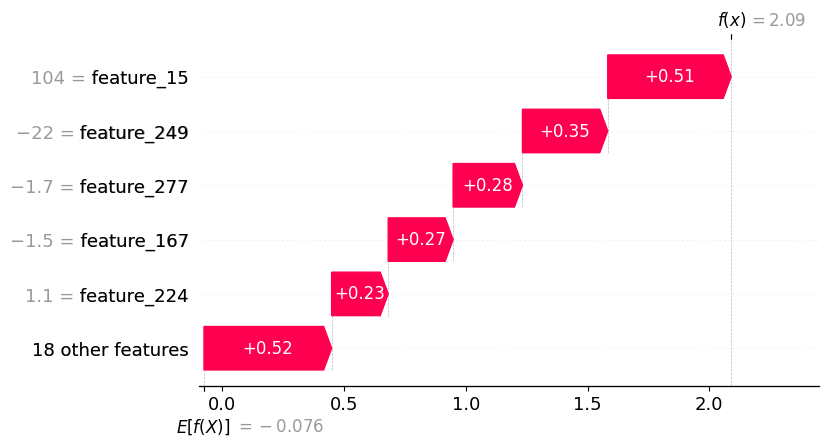

In [19]:
from shap import TreeExplainer, Explanation
from shap.plots import waterfall, beeswarm

explainer = TreeExplainer(model)
sv = explainer(X_test)
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=X_test.values, 
                  feature_names=X_test.columns)
idx = np.argmax( [y[1] for y in y_pred_prob])
waterfall(exp[idx], max_display=6)

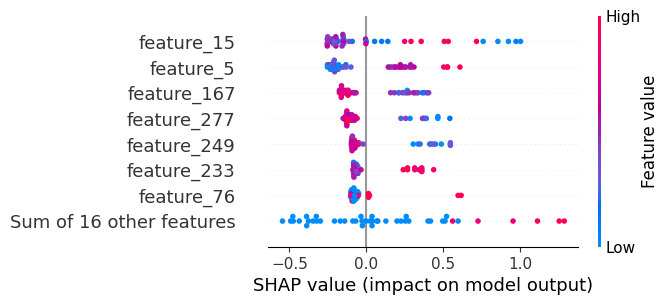

In [21]:
beeswarm(exp, plot_size=(5,3), max_display=8)

In [22]:
def wtdQuantile(df, n=10):
    var = 'pred'
    weight = 'sample_weight'
    if df[weight].unique()[0] == 1:
        quantiles = pd.qcut(df[var], n, labels=False, duplicates='drop')
        if quantiles.nunique() < n:
            # Occasionally if there are too many ties, we won't end up with 10 quantiles... this will break those ties in a sensible way.
            quantiles = pd.qcut(df[var].rank(method='first'), n, labels=False, duplicates='drop')
        return quantiles
    else:
        df = df.sort_values(var, ascending=True)
        cum_sum = df[weight].cumsum()
        cutoff = max(cum_sum) / n
        quantile = cum_sum / cutoff
        quantile[-1:] -= 1
        return quantile.map(int)

def calc_lift(y_true, y_pred, sample_weight, bins=10):
    df = pd.DataFrame(list(zip(y_true, y_pred, sample_weight)), columns = ['target','pred','sample_weight'])
    def cal_weight_avg(df):
        return (df['target'] * df.sample_weight).sum() / df.sample_weight.sum()
    natural_mean = cal_weight_avg(df)
    idx_positive_prob = 1
    df['bin'] = bins - wtdQuantile(df, n=bins)
    rdf = df.groupby('bin').apply(cal_weight_avg).reset_index()
    rdf.columns = ['bin', 'target']
    lift_positive = rdf.reset_index().sort_values('bin').target.values
    lift_index_positive = lift_positive / natural_mean
    # Reset the index again and calculate the averages
    def cal_avg(df):
        return df['target'].sum()
    rdf2 = df.groupby('bin').apply(cal_avg).reset_index()
    rdf2.columns = ['bin', 'target_cnt']  
    gain_pos_cnt = rdf2.reset_index().sort_values('bin').target_cnt.values
    gain_pos_cnt = gain_pos_cnt / gain_pos_cnt.sum()
    gain = np.cumsum(gain_pos_cnt)
    
    # Add the last decile values for the last bin
    gain = np.insert(gain, 0, 0)
    lift_positive = np.append(lift_positive, 0)
    lift_index_positive = np.append(lift_index_positive, 0)
    
    # Consolidate Results into Output Dataframe
    lift_df = {'baseline_percentage': natural_mean,
               'lift_percentage': lift_positive.tolist(),
               'baseline_index': idx_positive_prob,
               'lift_index': lift_index_positive.tolist(),
               'gain': gain.tolist()}
    lift_df.update({'deciles': [k for k, i in enumerate(lift_index_positive)]})
    return lift_df

In [23]:
    def plot_lift_gain(lift_dict):
        """Plots the lift and gain curves

        Args:
            save_path (str, optional): If none, saves a PNG to the path. Defaults to None.
        """
        m_lift = pd.DataFrame(lift_dict['Train'])
        v_lift = pd.DataFrame(lift_dict['Val'])
        h_lift = pd.DataFrame(lift_dict['Test'])
        m_lift['random'] = 1

        fig = make_subplots(rows=1, 
                            cols=2, 
                            subplot_titles=("Lift Curve", "Gain Curve"))
        # Lift traces
        fig.add_trace(
            go.Scatter(
                x=m_lift['deciles'], 
                y=m_lift['lift_index'],
                name='Training',
                legendgroup='group1',
                line=dict(color='#1f77b4', width=2)),
                row=1, col=1,
        )
        fig.add_trace(
            go.Scatter(
                x=v_lift['deciles'], 
                y=v_lift['lift_index'],
                name='Validation',
                legendgroup='group2',
                line=dict(color='#d62728', width=2)),
                row=1, col=1
        )
        fig.add_trace(
            go.Scatter(
                x=h_lift['deciles'], 
                y=h_lift['lift_index'],
                name='Holdout',
                legendgroup='group3',
                line=dict(color='#2ca02c', width=2)),
                row=1, col=1
        )
        # Gain traces
        fig.add_trace(
            go.Scatter(
                x=m_lift['deciles'], 
                y=m_lift['gain'],
                name='Training',
                legendgroup='group1',
                showlegend=False,
                line=dict(color='#d62728', width=2)),
                row=1, col=2
        )
        fig.add_trace(
            go.Scatter(
                x=v_lift['deciles'], 
                y=v_lift['gain'],
                name='Validation',
                legendgroup='group2',
                showlegend=False,
                line=dict(color='#1f77b4', width=2)),
                row=1, col=2
        )
        fig.add_trace(
            go.Scatter(
                x=h_lift['deciles'], 
                y=h_lift['gain'],
                name='Holdout',
                legendgroup='group3',
                showlegend=False,
                line=dict(color='#2ca02c', width=2)
                ),
                row=1, col=2
        )

        fig.add_shape(
            type='line', line=dict(dash='dash'),
            x0=0, x1=10, y0=1, y1=1,
            row=1, col=1
        )
        fig.add_shape(
            type='line', line=dict(dash='dash'),
            x0=0, x1=10, y0=0, y1=1,
            row=1, col=2
        )

        fig.update_layout(
            width = 800, 
            height = 400, 
            title = 'Lift & Gain Chart', 
            hovermode="x unified",
            xaxis1 = dict(
                tickmode = 'linear',
                tick0 = 1,
                dtick = 1),
            xaxis2 = dict(
                tickmode = 'linear',
                tick0 = 1,
                dtick = 1))
        fig.update_xaxes(title_text = 'deciles')
        fig.update_yaxes(title_text = "Gain", row=1, col=2)
        fig.update_yaxes(title_text = "Lift", row=1, col=1)
        fig.show()

In [24]:
lift_dict = {}
lift_dict['Train'] = calc_lift(y_train, y_train_pred, [1] * len(y_train))
lift_dict['Val'] = calc_lift(y_val, y_val_pred, [1] * len(y_val))
lift_dict['Test'] = calc_lift(y_test, y_test_pred, [1] * len(y_test))

In [25]:
plot_lift_gain(lift_dict=lift_dict)

In [28]:
recall_score(y_val, y_val_pred)

0.9375

In [26]:
recall_score(y_test, y_test_pred)

0.7307692307692307